## Problem 1: Power Analysis for the testing of Proportions

We're interested in the testing of uplift across two testing arms. This suggests comparison of proportionsand ratios. One simple test is an independence test for proportions. 

In [147]:
from statsmodels.stats.power import NormalIndPower
from matplotlib import pyplot as plt
count = np.arange(1, 100, 5)
nobs = [100]*len(count)
value = .5 ## Null proportion
for i in range(len(count)):
    stat, pval = proportions_ztest(count[i], nobs[i], value, alternative='larger')
    p = count[i] / nobs[i]
    res = "Test {p} < 0.5 : {pval}".format(p=p, pval=round(pval, 5))
    print(res)

Test 0.01 < 0.5 : 1.0
Test 0.06 < 0.5 : 1.0
Test 0.11 < 0.5 : 1.0
Test 0.16 < 0.5 : 1.0
Test 0.21 < 0.5 : 1.0
Test 0.26 < 0.5 : 1.0
Test 0.31 < 0.5 : 0.99998
Test 0.36 < 0.5 : 0.99823
Test 0.41 < 0.5 : 0.96637
Test 0.46 < 0.5 : 0.78889
Test 0.51 < 0.5 : 0.42072
Test 0.56 < 0.5 : 0.11338
Test 0.61 < 0.5 : 0.01206
Test 0.66 < 0.5 : 0.00037
Test 0.71 < 0.5 : 0.0
Test 0.76 < 0.5 : 0.0
Test 0.81 < 0.5 : 0.0
Test 0.86 < 0.5 : 0.0
Test 0.91 < 0.5 : 0.0
Test 0.96 < 0.5 : 0.0


Once we've observed a specific uplift we're interested in testing whether the observation is robust i.e. how much confidence should we have that the result reflects a genuine difference. Traditional frequentist tests use an effect size analysis to underwrite the conclusion of above tests. The strategy assumes a fixed value for statistical power: the probability of accepting the alternative hypothesis if it is true, and derives the value for a required sample size. 

In [122]:
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest

efs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
sample_required = []
for e in efs:
    s=zt_ind_solve_power(effect_size=e, power=.9, alpha=0.05, alternative='larger')
    sample_required.append(s)
    
df_e = pd.DataFrame({'ef': efs, 'samples': sample_required})
df_e

,ef,samples
0,0.01,171276.947013
1,0.02,42819.236753
2,0.05,6851.077881
3,0.10,1712.769470
4,0.20,428.192369
5,0.30,190.307719


These figures show that we can with the volume of our data arrive at large enough samples to justify the application of these effect sizes.

<AxesSubplot:xlabel='ef', ylabel='samples'>

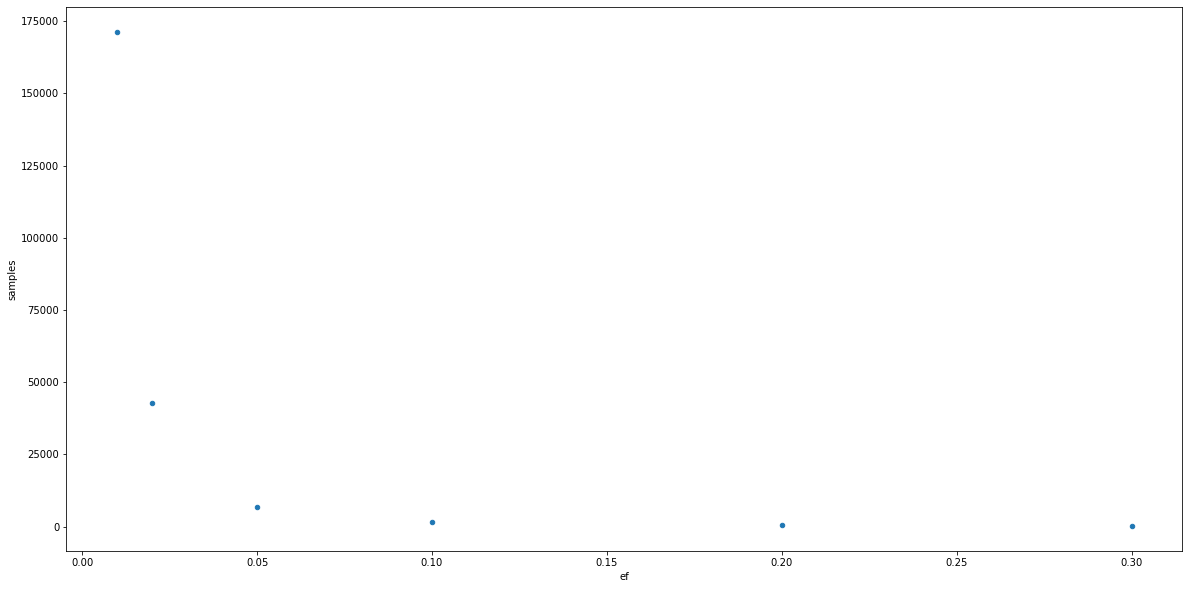

In [149]:
df_e.plot.scatter(x='ef', y='samples', figsize=(20, 10), style='l')

### Potential Solution: Be explicit about expected effect size and only evaluate where sample size is achieved


## Problem 2: Multiple Comparisons

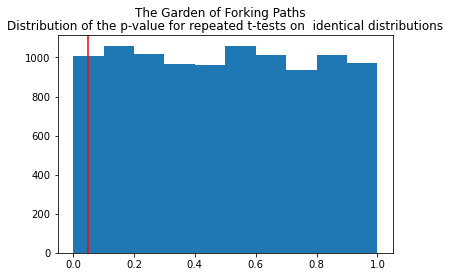

In [42]:
from statsmodels.stats.weightstats import ttest_ind
import numpy as n
import pandas as pd
significance = 0.05
n_comparisons = 10000

p_values = []
for i in range(n_comparisons):  
    norm1 = np.random.normal(8, 1, 100)
    norm2 = np.random.normal(8, 1, 100)
    pvalue = ttest_ind(norm1, norm2, 'two-sided')
    p_values.append(pvalue[1])

plt.hist(p_values)
plt.title("Distribution of the p-value for repeated t-tests on  identical distributions")
plt.suptitle("The Garden of Forking Paths")
plt.axvline(significance, c='red')

In [33]:
pvalue[0]

0.5172252933836022

### Potential Solution Family Error Rate Analysis and P-value Corrections

In [175]:
mu, sigma = 10, 3 # mean and standard deviation
group1 = np.random.normal(mu, sigma, 50)

mu, sigma = 11, 3 # mean and standard deviation
group2 = np.random.normal(mu, sigma, 50)

mu, sigma = 12, 3 # mean and standard deviation
group3 = np.random.normal(mu, sigma, 50)

mu, sigma = 13, 3 # mean and standard deviation
group4 = np.random.normal(mu, sigma, 50)


df = pd.DataFrame()
df['treatment1'] = group1
df['treatment2'] = group2
df['treatment3'] = group3
df['treatment4'] = group4

# Stack the data (and rename columns):

stacked_data = df.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'treatment',
                                             0:'result'})
# Show the first 8 rows:

stacked_data.head(8)

,id,treatment,result
0,0,treatment1,12.513235
1,0,treatment2,13.548095
2,0,treatment3,9.976199
3,0,treatment4,15.225109
4,1,treatment1,11.127143
5,1,treatment2,12.053641
6,1,treatment3,15.609431
7,1,treatment4,11.086977


In [176]:
from statsmodels.sandbox.stats.multicomp import MultiComparison
# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(stacked_data['result'],
                            stacked_data['treatment'])

# Show all pair-wise comparisons:

# Print the comparisons

MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
treatment1,treatment2,0.2546,0.9,-1.4378,1.947,False
treatment1,treatment3,1.7787,0.0352,0.0863,3.471,True
treatment1,treatment4,2.9043,0.001,1.2119,4.5967,True
treatment2,treatment3,1.5241,0.0939,-0.1683,3.2165,False
treatment2,treatment4,2.6497,0.001,0.9573,4.3421,True
treatment3,treatment4,1.1256,0.3144,-0.5668,2.818,False


ANOVA analysis uses an F test to determine if group participation has significant differences on an outcome

In [208]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('result ~ C(treatment)', data=stacked_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatment),278.424033,3.0,8.703554,0.000019
Residual,2089.993358,196.0,NaN,NaN


A more complex example with interaction effects between groups

In [214]:
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


In [221]:
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


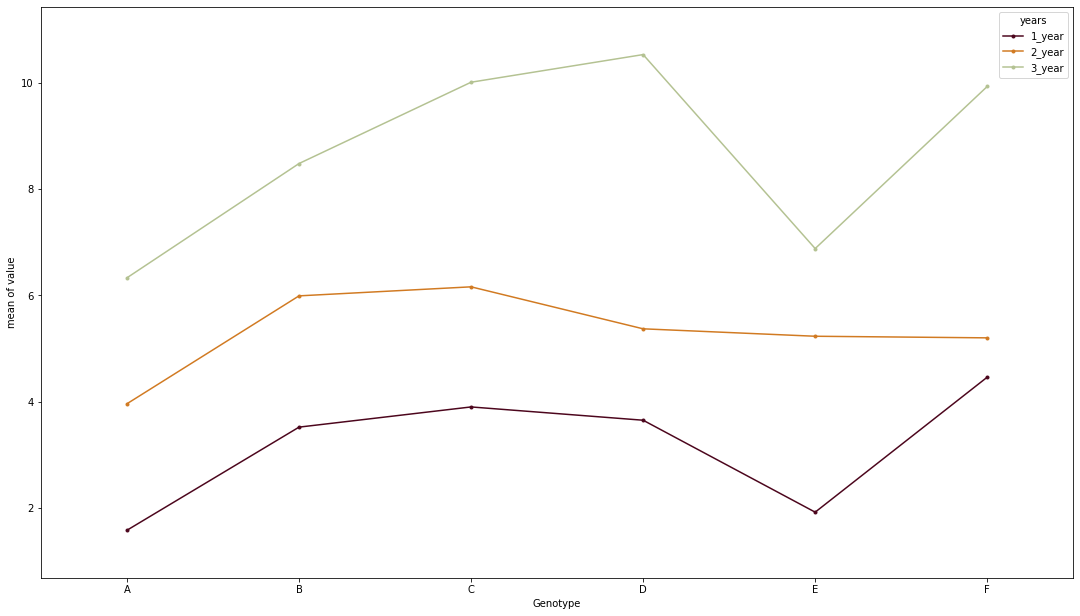

In [225]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(x=d_melt['Genotype'], trace=d_melt['years'], response=d_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
fig.set_size_inches(18.5, 10.5)
plt.show()